# VAE-CNN@MNIST

Do VAE on MNIST using CNNs.

In [18]:
from google.colab import drive
drive.mount('/content/gdrive')

import os
workspace = '/content/gdrive/MyDrive/Colab/VAE-CNN@MNIST'
os.chdir(workspace)
os.listdir()

ModuleNotFoundError: No module named 'google.colab'

## Import and preparations

In [19]:
# generic usage
import os
# import sys
import numpy as np
# import math
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
import random
# import pickle
from datetime import datetime

# basic torch packages
import torch
from torch import optim
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.autograd import Variable
# import torchvision
# from PIL import Image
from collections import OrderedDict
import importlib

# for the MNIST
from torchvision import transforms
import torchvision.utils
from torchvision.utils import save_image
from torchvision.datasets import MNIST
from torchvision.transforms import ToPILImage


## HyperParameters of the NN

The CNN channel numbers are written in the net class.

In [20]:
hyper_params = {
    "data_path": "./data",  # point to the upper dir of the data dir
    # "device": "cpu",
    "device": "cuda",
    "epoch_num": 100,
    "batch_size": 256,
    "lr_rate": 0.001,
}

[print(i[0], "->", i[1]) for i in hyper_params.items()];


data_path -> ./data
device -> cuda
epoch_num -> 100
batch_size -> 256
lr_rate -> 0.001


## Data Preparation

In [21]:
img_transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

dataset = MNIST(
    root="./data",
    transform=img_transform,
    download=True,
)

In [22]:
dataloader = DataLoader(
    dataset = dataset,
    batch_size=hyper_params["batch_size"],
    shuffle=True,
    # num_workers=2,
    # pin_memory=True,
)

print(len(dataloader))

235


## Net Definition

In [23]:
try:
    importlib.reload(NET)
except NameError as err:
    import NET
    print("first import NET.py, not reload")
    pass


In [24]:
model = NET.MODEL(hyper_params).to(hyper_params["device"])
print("Training on {} device".format(hyper_params['device']))
# print(model)


Training on cuda device


## run

In [25]:
optimizer = optim.Adam(model.parameters(), lr=model.hpm["lr_rate"])


In [26]:
from WatchDog import *
wd = WatchDog(mov_avg_len=10, ratio_max=10)  # the watch dog


In [ ]:
# epoch_num = model.hpm["epoch_num"]
epoch_num = 200
batch_print_num = len(dataloader) // 3

model.train()
for epoch_idx in range(epoch_num):
    wd.add_epoch_loss()
    for batch_idx, (x, _) in enumerate(dataloader):
        x = x.to(model.hpm['device'])
        optimizer.zero_grad()
        recon_x, mu, logvar = model(x)
        loss = model.loss_func(recon_x, x, mu, logvar, beta=0.1)
        if wd.check_batch_loss(loss.detach().cpu().numpy() / x.size(0)):
            break
        loss.backward()
        optimizer.step()
        wd.cum_epoch_loss(loss.item())
        if (batch_idx+1) % batch_print_num == 0:
            print("Run\tEpoch: [{}/{}]  Item: [{}/{}]  AvgLoss: {:.4e}".format(
                epoch_idx+1, epoch_num,
                (batch_idx + 1) * model.hpm["batch_size"], len(dataloader.dataset),
                wd.show_batch_loss_avg()))
    if wd.toStop:
        optimizer.zero_grad()
        print("Tip\tEarly Stop at Epoch: [{}/{}]  LossRatio: {:.1f}".format(
            epoch_idx+1, epoch_num, wd.ratio_this))
        break
    print("Run\tEpoch [{}/{}]  AvgLoss: {:.4e}".format(
        epoch_idx+1,
        epoch_num,
        wd.avg_epoch_loss(len(dataloader.dataset))))

print("Tip\tTraining finished")
model.eval();


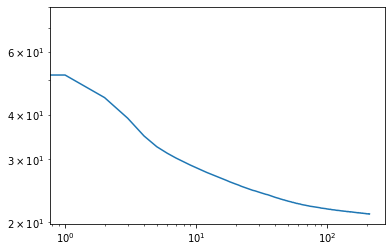

In [13]:
plt.plot(wd.epoch_loss_arr)
plt.xscale('log')
plt.yscale('log')
plt.show()

[9, 2, 7, 4, 9, 2, 2, 7]
[0, 4, 1, 8, 3, 9, 7, 6]
[]


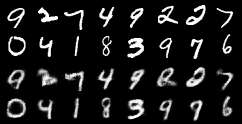

In [14]:
test_idxes = random.sample(range(len(dataloader.dataset)), 16)
test_datas = torch.stack([dataset[i][0] for i in test_idxes])
test_labels = [dataset[i][1] for i in test_idxes]
pred_datas, _, _ = model.forward(test_datas.to(model.hpm['device']))
pred_datas = pred_datas.data.cpu()

for i in range(len(test_idxes)//8):
    print(test_labels[i*8:(i+1)*8])
print(test_labels[len(test_labels)//8 * 8:])

concat_datas = torch.concat(
    [torchvision.utils.make_grid(test_datas, nrow=8),
    torchvision.utils.make_grid(pred_datas, nrow=8)], dim=1)
ToPILImage()(concat_datas)


## Save

In [16]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
timestamp

'20220423_152115'

In [17]:
save_names = {
    'model': './data/VAE-CNN@MNIST-model-'+timestamp+'.pth',
    'state_dict': './data/VAE-CNN@MNIST-state_dict-'+timestamp+'.pth',
    'loss': './data/VAE-CNN@MNIST-loss-'+timestamp+'.pth',
}

# os.chdir(workspace)

torch.save(model.state_dict(), save_names['state_dict'])
# model.load_state_dict(torch.load('./data/VAE-CNN@MNIST-state_dict.pth'))
torch.save(model, save_names['model'])
# model =torch.load('./data/VAE-CNN@MNIST-model.pth')
torch.save(wd.epoch_loss_arr, save_names['loss'])
